In [37]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from torch.utils.data import TensorDataset, DataLoader
import logging
from tqdm.notebook import tqdm

In [38]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
data_logger = logging.getLogger(" DATA")


```markdown
we are using `data0` and `data1` for training, and `data2` for testing. This setup allows us to train our model on a diverse set of data and evaluate its performance on a separate test set to ensure generalization.
```

In [39]:
#! Data processing

def load_data():
    img_data_0 = np.load('../data/data0.npy')
    img_data_1 = np.load('../data/data1.npy')
    img_data_2 = np.load('../data/data2.npy')
    img_label0 = np.load('../data/lab0.npy')
    img_label1 = np.load('../data/lab1.npy')
    img_label2 = np.load('../data/lab2.npy')

    xtrain = torch.tensor(np.concatenate((img_data_0, img_data_1)),dtype=torch.float32).unsqueeze(1)
    xtest = torch.tensor(img_data_2,dtype=torch.float32).unsqueeze(1)

    ytrain = torch.tensor(np.concatenate((img_label0, img_label1)),dtype=torch.float32)
    ytest = torch.tensor(img_label2,dtype=torch.float32)

    train_dataset = TensorDataset(xtrain, ytrain)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    test_dataset = TensorDataset(xtest, ytest)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    data_logger.info("Data loaded successfully")
    return {
        "train_dataloader": train_dataloader,
        "test_dataloader": test_dataloader,
        "train_dataset": train_dataset,
        "test_dataset": test_dataset,
        "xtrain": xtrain,
        "xtest": xtest,
        "ytrain": ytrain,
        "ytest": ytest
    }



In [40]:
#! visualisation

def visualize(test_dataloader,train_dataloader):
    test_data_iter = iter(test_dataloader)
    test_images, test_labels = next(test_data_iter)

    # Plot the first 4 images in the batch
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
    for i in range(4):
        ax = axes[i]
        ax.imshow(test_images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f'Label: {test_labels[i].item()}')
        ax.axis('off')
    plt.show()
    # Iterate through the DataLoader
    for i, (inputs, labels) in enumerate(train_dataloader):
        print(f"Batch {i + 1}:")
        print(f"  Input shape: {inputs.shape}")
        print(f"  Labels shape: {labels.shape}")
        # Break after the first batch to limit output (optional)
        break
    data_logger.info("Data visualisation done")


In [41]:
model_logger = logging.getLogger("MODEL")

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the flattened size
        
        self.fc1 = nn.Linear(64*4*20, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 37) 

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256*2*10)  # Use dynamically computed size

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x

In [43]:
class Model:
    def __init__(self):
        pass

    def set_params(self,device,net,data,optim=None,criterion=nn.CrossEntropyLoss()):
        self.device = device
        self.net = net
        self.data = data
        self.optim = optim
        self.criterion = criterion
        model_logger.info('Model Parameters Set')

    def train(self,epochs=10,lr=0.001):
        self.net.to(self.device)
        self.net.train()
        self.optim = optim.Adam(self.net.parameters(), lr=lr) if optim is None else optim
        model_logger.info('Start Training')
        for epoch in tqdm(range(epochs), desc="Training Progress"):
            running_loss = 0.0
            for i, data in enumerate(self.data["train_dataloader"], 0):
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                self.optim.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels.long())
                loss.backward()
                self.optim.step()
                running_loss += loss.item()
            tqdm.write(f"Epoch {epoch + 1} : Loss: {running_loss / len(self.data['train_dataloader'])}")
        model_logger.info('Finished Training')

    def test(self):
        self.net.to(self.device)
        self.net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in self.data["test_dataloader"]:
                images, labels = data[0].to(self.device), data[1].to(self.device)
                outputs = self.net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        model_logger.info(f'Accuracy of the network on the test images: {100 * correct / total}%')

    def save_model(self,path):
        torch.save(self.net.state_dict(), path)
        model_logger.info('Model Saved')

    def load_model(self,path):
        self.net.load_state_dict(torch.load(path))
        model_logger.info('Model Loaded')


2025-01-08 20:28:32,275 -  DATA - INFO - Data loaded successfully


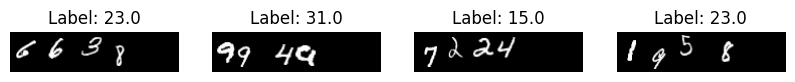

2025-01-08 20:28:32,339 -  DATA - INFO - Data visualisation done
2025-01-08 20:28:32,398 - MODEL - INFO - Model Parameters Set
/tmp/ipykernel_32223/1127707819.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

Batch 1:
  Input shape: torch.Size([64, 1, 40, 168])
  Labels shape: torch.Size([64])


In [ ]:
data = load_data()
visualize(data["test_dataloader"],data["train_dataloader"])

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(net.parameters(), lr=0.001)

model = Model()
model.set_params(device,net,data,optim,criterion)
model.load_model('./model.pth')

In [45]:
model.test()

2025-01-08 20:28:33,284 - MODEL - INFO - Accuracy of the network on the test images: 30.12%
